In [1]:
"""
This notebook is published for the purpose of illustrating the theory and algorithm developed in 

Calmon, L., Schaub, M.T. and Bianconi, G. (2023) 
‘Dirac signal processing of higher-order topological signals’, 
New Journal of Physics, 25(9), p. 093013. 
doi:10.1088/1367-2630/acf33c.


(c) Lucille Calmon, Michael Schaub & Ginestra Bianconi


Data loaded in this notebook was pre-processed for 
Refs[2,3] and is available at [4]

Please cite the following references when using and modifying this code:

[1] Calmon, L., Schaub, M.T. and Bianconi, G. (2023) 
‘Dirac signal processing of higher-order topological signals’, 
New Journal of Physics, 25(9), p. 093013. 
doi:10.1088/1367-2630/acf33c.

[2] Schaub, M.T., Benson, A.R., Horn, P., Lippner, G., and Jadbabaie, A. (2020) 
‘Random walks on simplicial complexes and the normalized Hodge 1-Laplacian’, 
SIAM Review, 62(2), pp. 353–391. doi:10.1137/18m1201019. 

[3] Roddenberry, T. Mitchell, Nicholas Glaze, and Santiago Segarra. 
"Principled simplicial neural networks for trajectory prediction." 
International Conference on Machine Learning. PMLR, 2021.

[4] https://github.com/nglaze00/SCoNe_GCN/tree/master

[4] Lumpkin, Rick; Centurioni, Luca (2019). 
Global Drifter Program quality-controlled 6-hour interpolated data from ocean surface drifting buoys. 
NOAA National Centers for Environmental Information. Dataset. 
https://doi.org/10.25921/7ntx-z961.

"""

#Import of packages
import pandas as pd
import palettable
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#import geopandas
#import shapely

import math
import scipy
import scipy.stats
import numpy as np
import random
# setup plotting tools
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors
import matplotlib.cm as cm
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec as GS
#from util import lexsort_rows

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
from scipy.sparse.linalg import eigsh
from scipy.sparse import csc_matrix
from sympy import *
from numpy.linalg import inv
import itertools
from itertools import groupby
from functools import reduce
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import operator
from operator import itemgetter
from scipy.spatial import Delaunay
import networkx as nx
from scipy.sparse import csr_matrix
from scipy.sparse import csc_matrix
from matplotlib.patches import Polygon
from pylab import rcParams
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

%run -i buoy_data.py


#The above file when ran returns in particular:
#boundary matrices B1, B2, 
#the node list, 
#the edge list, 
#triangle list, 
#Graph object from networkx
#flows: a matrix containing the edge flows of each of the 339 buoys.
#traj_nodes: the paths from node to node for each of the 339 buoys
#and other information about the data

%run -i ../Functions_Dirac_signal_proc.py

/Users/admin/Dropbox/PhD/Dirac_Signal_processing/code m/github/Functions_Dirac_signal_proc.py:287: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  def plot_NL(s,list_edges, list_triangle, pos, ax, norm, the_map = mpl.cm.get_cmap('coolwarm'), edge_width_factor = 20):


In [2]:
#Set-up of the data: loads the edge and triangle list
N=len(node_list)
L=len(edge_list)
T=len(face_list)
print(N,L,T)
node_list = node_list+1 #index to start at 1
edge_list = (np.array(edge_list)+1).tolist()
list_triangles = (np.array(face_list)+1).tolist()

133 320 186


In [3]:

D1,D2 = get_D(B1,B2) # builds the Diracs

w1, v1 = np.linalg.eigh(D1) # eigenvalues and eigenvectors
w2, v2 = np.linalg.eigh(D2)


# Real dataset Visualisation:

In [4]:
#Preparing the signal:

D_tot = D1 + D2
s_l = np.concatenate((np.zeros(N),sum(flows,0),np.zeros(T)),0) #aggregate all trajectories on edges
s_gen = s_l + D_tot.dot(s_l) #build the signal on all simplices by projecting up and down the 


In [5]:

D_one = False  #flag to switch between D1 and D2 signal processing. True for D1, and False for D2 signal processing.
w = w1 if D_one==True else w2
v = v1 if D_one==True else v2
D = D1 if D_one==True else D2
vinv = np.linalg.inv(v)
w_real = w
mask_nonzero = (~np.isclose(w_real, 0))
v_nonzero = v[:, mask_nonzero] #all non-zero eigenvectors
w_nonzero = w_real[mask_nonzero] #all non-zero eigenvalues


#define the signal:
s = D.dot(np.linalg.pinv(D)).dot(s_gen) #projection onto image of D1 or D2
s = s/np.linalg.norm(s) #normalise the signal
m_target = ((np.transpose(s)).dot(D)).dot(s)/((np.transpose(s)).dot(s)) #True mass


#define the noise
noise = np.random.normal(0,1,s.shape[0])/np.sqrt(len(w_nonzero))
noise = ((v_nonzero).dot(np.transpose(v_nonzero))).dot(noise) #ensures the noise is non-harmonic
beta= 1 #half noise half signal
s_noisy = s + beta*noise
s_true =s
snr = np.linalg.norm(s)**2/np.linalg.norm(beta*noise)**2

#processing parameters:
gamma=0.5 if D_one == True else 1 #nodes links
tol = 0.0001
m_0 = 1.6 if D_one == False else 1.1
eps = 0.3

#process
list_m, list_error_m, list_it, m, s_est_m = optimize_m(w,v,vinv,D,s_noisy,s_true,m_0,gamma,tol, epsilon = eps)

#ranks the minimum and maximum of the signal values -- used to set the color scale later.

low, *_, high = sorted((np.concatenate((s_true,s_est_m,s_noisy))))

print(snr, beta, gamma, tol, m_0, np.linalg.norm(s_true-s_est_m))

1.0753874301950173 1 1 0.0001 1.6 0.6511710200171402


In [6]:
#Set the color map and color scale

if D_one == False:
    the_map=palettable.scientific.diverging.Berlin_20.mpl_colormap
    prova=mpl.cm.get_cmap(the_map,12)

    jc1=np.concatenate((np.linspace(0,0.25,120),np.linspace(0.26,0.495,7)),axis=0)
    jc2=np.concatenate((np.linspace(0.505,0.74,10),np.linspace(0.75,1.0,120)),axis=0)

    jc=np.concatenate((jc1,jc2),axis=0)
    prova2=prova(jc)
    the_map = ListedColormap(prova2)
    norm = mpl.colors.SymLogNorm(linthresh = 0.1, linscale = 10, vmin=-max(abs(low),high), vmax=max(abs(low),high), clip = True,base = 10)

else:
    the_map=palettable.scientific.diverging.Berlin_20.mpl_colormap
    norm = mpl.colors.SymLogNorm(linthresh = 0.005, linscale = 1, vmin=-max(abs(low),high), vmax=max(abs(low),high), clip = True,base = 10)

/var/folders/pq/mypssjvs1xs0k9vkzrrw07b00000gn/T/ipykernel_24060/3066172549.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  prova=mpl.cm.get_cmap(the_map,12)


(-32.0, -10.0)

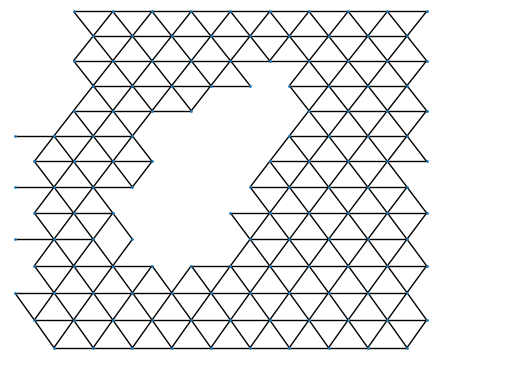

In [7]:
# defines the position of the nodes:
G = nx.Graph()
G.add_edges_from(edge_list)

Pos_XY = {}
Pos = {}
for i in np.arange(G.number_of_nodes()):
    Pos_XY[i+1] = Hexcenters[i] #from the initial python file ran in the preamble
    Pos[i+1]= xy_to_long_lattitude(Hexcenters[i])

fig, ax = plt.subplots()
nx.draw(G,Pos,node_size=1,ax=ax)
ax.set_xlim([38,59])
ax.set_ylim([-32,-10])

#nx.draw_networkx_labels(G,Pos)

/Users/admin/Dropbox/PhD/Dirac_Signal_processing/code m/github/Functions_Dirac_signal_proc.py:424: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  edges = nx.draw_networkx_edges(


1.0753874301950173 1 1 0.0001 1.6 0.6511710200171402


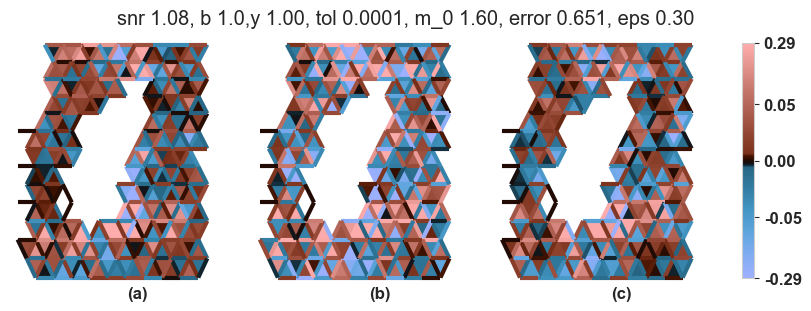

In [8]:
%matplotlib inline

plot_func = plot_NL if D_one ==True else plot_LTv1 #selects function ot use to plot

faces = list_triangles

pos = Pos
rcParams['lines.linewidth'] = 2
font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

fig = plt.figure(figsize = (8, 3), constrained_layout=True)

gs = GS(1, 3, figure=fig, left=0.02, right=0.2, wspace=0.0, hspace=0)
#ax1 = fig.add_subplot(gs[0,0:3])
ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=1))
ax2 = plt.subplot(gs.new_subplotspec((0, 1), colspan=1))
ax3 = plt.subplot(gs.new_subplotspec((0, 2), colspan=1))

if low == 0: #to plot the error instead of the signal
    the_map = mpl.cm.get_cmap('Reds')
    norm = mpl.colors.Normalize(vmin=0, vmax=high, clip=True)

plot_func(s_true, edge_list, faces, pos, ax1,norm, the_map)
mapper = plot_func(s_noisy, edge_list, faces, pos, ax2, norm, the_map)
plot_func(s_est_m, edge_list, faces, pos, ax3,norm, the_map)

ax1.annotate('(a)',xy = (0.5, 0.005), xycoords = 'axes fraction')
ax2.annotate('(b)',xy = (0.5, 0.005), xycoords = 'axes fraction')
ax3.annotate('(c)',xy = (0.5, 0.005), xycoords = 'axes fraction')

cax = ax3.inset_axes([1.06, 0.08, 0.05, 0.9])

if low==0:
    plt.colorbar(mapper, ticks = np.linspace(low,high,5),format = '%.2f')
else:
    if D_one == False:
        ticks= [-max(abs(low),high),-0.05, 0, 0.05,max(abs(low),high)]
        color_bar = plt.colorbar(mapper, ticks =ticks, cmap = the_map, norm = norm, cax = cax, spacing = 'uniform', format = '%.2f')
    else: 
        ticks= np.concatenate((-np.geomspace(0.005, max(abs(low),high), 3)[::-1], [0], np.geomspace(0.005, max(abs(low),high), 3)))
        color_bar = plt.colorbar(mapper, ticks = ticks, cmap = the_map, norm = norm, cax = cax, spacing = 'uniform', format = '%.2f')
        #formatter = plt.LogFormatter(labelOnlyBase = False, linthresh = 0.005, minor_thresholds = (10, 0.4))

for ax in [ax1,ax2,ax3]:
    ax.set_xlim([37.5,59])
    ax.set_ylim([-32,-9.5])
    
color_bar.ax.minorticks_off()
fig.suptitle('snr %.2f, b %.1f,y %.2f, tol %.4f, m_0 %.2f, error %.3f, eps %.2f' %(snr, beta, gamma, tol, m_0, np.linalg.norm(s_true-s_est_m),eps))

print(snr, beta, gamma, tol, m_0, np.linalg.norm(s_true-s_est_m))

# Mass sweep

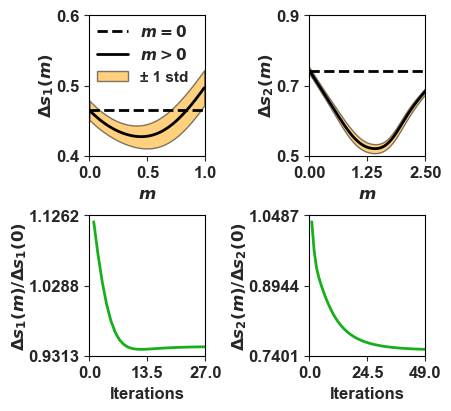

In [9]:
%matplotlib inline
rcParams['lines.linewidth'] = 2
font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

fig = plt.figure(figsize = (4.4, 4), constrained_layout=True)

gs = GS(2, 2, figure=fig, left=0.05, right=0.2, wspace=0.0, hspace=0)

ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=1))
ax2 = plt.subplot(gs.new_subplotspec((0, 1), colspan=1))
axtop = [ax1,ax2]
    
ax4 = plt.subplot(gs.new_subplotspec((1, 0), colspan=1))
ax5 = plt.subplot(gs.new_subplotspec((1, 1), colspan=1))
axbot = [ax4,ax5]

#parameters
beta = 0.6
gamma= [1,1.5]
D_one = [True, False]
m_0 = [1.1,3]
tol = 0.001
range_mass = [[0,1], [0,2.5]]

for i in [0,1]:
    w,v,D,vinv = get_wvd(D_one[i],D1,D2)
    s = get_signal(s_gen, D)

    #average mass sweep
    error_avg, error_std, error0_avg, error0_std, mass_avg, mass_std, list_mass = mass_sweep_avg(s, beta, gamma[i], 10, w, v, D, vinv, range_mass[i][0], range_mass[i][1])
    
    axtop[i].plot(list_mass,error0_avg*np.ones(len(list_mass)), 'k--', label='$m=0$')
    axtop[i].plot(list_mass,error_avg, 'k', label='$m>0$')
    axtop[i].fill_between(list_mass, error_avg-error_std,error_avg+error_std, color='orange', edgecolor = 'black', alpha=0.5,label = '± 1 std')
    axtop[i].set_xlabel('$m$', fontweight = 'bold')

    #learning curve for m
    s_true, s_noisy, m_target, snr = add_noise(s,w,v,D,beta)
    list_m, list_error_m, list_it, m, s_est_m = optimize_m(w,v,vinv,D,s_noisy,s_true,m_0[i],gamma[i],tol)
    s_est = process(w,v,vinv, s_noisy, 0, gamma[i])
    error = np.linalg.norm(s_est - s_true,2)
    
    axbot[i].plot(list_it, list_error_m/error, 'xkcd:green')
    axbot[i].set_xlim(xmin = 0, xmax = max(list_it))
    axbot[i].set_xlabel('Iterations', fontweight = 'bold')

ax1.legend(frameon=False, borderpad= 0, fontsize = 11, loc =2)
    
ax1.set_xlim(range_mass[0])
ax2.set_xlim(range_mass[1])
ax1.set_ylim([0.4, 0.6])
ax2.set_ylim([0.5, 0.9])
ax1.set_ylabel('$\Delta s_1(m)$',labelpad =0)
ax2.set_ylabel('$\Delta s_2(m)$',labelpad =0)
ax4.set_ylabel('$\Delta s_1(m)/\Delta s_1(0)$',labelpad =0)
ax5.set_ylabel('$\Delta s_2(m)/\Delta s_2(0)$',labelpad =0)
#ax1.legend(frameon=false, borderpad= 0, fontsize = 10)

for ax in [ax1,ax2,ax4,ax5]:
    ax.tick_params('both',direction='out', labelsize =12, bottom=True, top=False, left=True, right=False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.yaxis.set_major_locator(plt.LinearLocator(3))
    ax.xaxis.set_major_locator(plt.LinearLocator(3))


In [ ]:
#to replot panel i of the learning curves
m_0 = [1.1,3.5]
tol = 0.0001
i=1
axbot[i].clear()
w,v,D,vinv = get_wvd(D_one[i],D1,D2)
s = get_signal(s_gen, D)
s_true, s_noisy, m_target, snr = add_noise(s,w,v,D,beta)
list_m, list_error_m, list_it, m, s_est_m = optimize_m(w,v,vinv,D,s_noisy,s_true,m_0[i],gamma[i],tol)
s_est = process(w,v,vinv, s_noisy, 0, gamma[i])
error = np.linalg.norm(s_est - s_true,2)
    
axbot[i].plot(list_it, list_error_m/error, 'xkcd:green')
axbot[i].set_xlim(xmin = 0, xmax = max(list_it))
axbot[i].set_xlabel('Iterations', fontweight = 'bold')

for ax in [ax4,ax5]:
    ax.tick_params('both',direction='out', labelsize =12, bottom=True, top=False, left=True, right=False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.xaxis.set_major_locator(plt.LinearLocator(3))

ax4.set_ylabel('$\Delta s_1(m)/\Delta s_1(0)$',labelpad =0)
ax5.set_ylabel('$\Delta s_2(m)/\Delta s_2(0)$',labelpad =0)

In [ ]:
#annotate the figure
ax1.annotate('(a)',xy = (0.86, 0.9), xycoords = 'axes fraction')
ax2.annotate('(b)',xy = (0.86, 0.9), xycoords = 'axes fraction')
ax4.annotate('(c)',xy = (0.86, 0.9), xycoords = 'axes fraction')
ax5.annotate('(d)',xy = (0.86, 0.9), xycoords = 'axes fraction')
